In [30]:
# Packages 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import seaborn as sns
HEIGHT_CORRECTION = 21.2/26.654 # AFM Height correction (measured wrt calibration sample)
# Update plotting parameters
params = {'legend.fontsize': 'xx-large',         
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large',
          'font.sans-serif': "Arial",
          'font.family': "sans-serif",
          'figure.figsize': (6, 3),
         }
sns.set_style("whitegrid", {'axes.grid' : False})
plt.rcParams.update(params)

In [31]:
def sinprofile(x, period, amplitude, offset_y, offset_x):
    # Sin^2 fit 
    y = amplitude*np.sin((x-offset_x)*np.pi/period)**2.+offset_y
    return y

def gaussprofile(x, period, radius, amplitude, offset_y, offset_x):
    # Gaussian fit
    sigma = radius/2.355 # 2sqrt(2log(2))
    y = amplitude*(1.0-np.exp(-np.square((x % period)-offset_x)/2./sigma**2.))+offset_y
    return y

In [32]:
def analyze_afm(data_file, true_period, params):
    ''' Reads AFM cut data and fits with sin^2 profile '''
        
    data = np.loadtxt(data_file)
    
    try: 
        savgol_window = params['savgol_window']
        savgol_order = params['savgol_order']
    except KeyError: 
        savgol_window, savgol_order = 21,5
    heights_up = params['heights_up']
    heights_do = params['heights_do']    
    widths_up = params['widths_up']
    widths_do = params['widths_do']  
    
    y0 = data[:,1]
    x = data[:,0]
    y = savgol_filter(y0, savgol_window, savgol_order)
  
    peaks_up, _ = find_peaks(y, height=heights_up, width = widths_up)
    peaks_do, _ = find_peaks(-y, height=heights_do, width = widths_do)
    periods = np.concatenate([np.array(np.diff(x[peaks_up])), np.array(np.diff(x[peaks_do]))])
    xl_list, xr_list, hole_diam_list, depth_list = [], [], [], [] 
    for peak in peaks_up[:-1]:
#         print(x[peak])
        loc_peak_do = np.where(x[peaks_do]>x[peak])[0][0]
        mean_height = (y[peaks_do[loc_peak_do]]+y[peak])/2.
        depth = y[peak]-y[peaks_do[loc_peak_do]]
#         print(loc_peak_do, mean_height)
        xl_ind = np.where(y[peak:peaks_do[loc_peak_do]]<mean_height)[0][0] + peak
        xr_ind = np.where(y[peaks_do[loc_peak_do]:-1]>mean_height)[0][0] + peaks_do[loc_peak_do]
        xl = x[xl_ind]
        xr = x[xr_ind]        
        hole_diam = xr - xl
        xl_list.append(xl_ind)
        xr_list.append(xr_ind)
        hole_diam_list.append(hole_diam)
        depth_list.append(depth)
    xl_list = np.array(xl_list)
    xr_list = np.array(xr_list)
    hole_diam_list = np.array(hole_diam_list)
    depth_list = np.array(depth_list)    
    
    # Correction factor due to AFM miscalibration
    correction_factor = true_period/np.mean(periods)
    corrected_periods = [p*correction_factor for p in periods]
    corrected_hole_diam_list = [d * correction_factor for d in hole_diam_list]
    
    # Rescaling
    x = x * correction_factor
    y = y * HEIGHT_CORRECTION
        
    # Plotting
    plt.plot(x, y0, '.', label = "raw data")
#     plt.plot(x, y, label = "filtered")
#     plt.plot(x[peaks_up], y[peaks_up], "x", label = "peaks (up)")
#     plt.plot(x[peaks_do], y[peaks_do], "x", label = "peaks (down)")    
    
    # Fitting to sinusoidal profile
    fit_func = sinprofile
#     fit_func = gaussprofile
    p0 = [np.mean(periods)*correction_factor, np.mean(depth_list)/2.*HEIGHT_CORRECTION, np.mean(y), 0.] # sin-like
#     p0 = [np.mean(periods)*correction_factor, np.mean(corrected_hole_diam_list)/2.0, np.mean(depth_list)/2.*HEIGHT_CORRECTION, np.mean(y), -0.05] # gauss-like
    popt, pcov = curve_fit(fit_func, x, y0, p0 = p0)
    plt.plot(x, fit_func(x, *popt), 'r-.')    
    
#     plt.plot(x[xl_list], y[xl_list], "r+", label = "mid-depth")
    plt.plot(x[xr_list], y[xr_list], "r+", label = "fit")
    plt.xlabel("Position ($\mu$m)"); plt.ylabel("Height (nm)")
#     plt.show()
    
    print("AFM Data from {0}".format(data_file))
    # Calculating and applying correction factor 
    print("Measured list of periods: {}".format(periods))
    print("Avg = {0} +/- {1}".format(np.mean(periods), np.std(periods)))    

    print("CORRECTION FACTOR = {0}".format(correction_factor))
    print("Corrected list of periods: {}\n".format(corrected_periods))
    
    print("Corrected list of diameters: {}".format(corrected_hole_diam_list))
    print("Avg = {0} +/- {1}".format(np.mean(corrected_hole_diam_list), np.std(corrected_hole_diam_list)))        
    
    corrected_depth_list = [d * HEIGHT_CORRECTION for d in depth_list]
    print("Corrected list of depths: {}".format(corrected_depth_list))
    print("Avg = {0} +/- {1}".format(np.mean(corrected_depth_list), np.std(corrected_depth_list)))            
    
    print("Summary: period = {0} (corrected by factor {1})\n".format(true_period, correction_factor))
    print("Diameter = {0} +/- {2} nm , Depth = {1} +/- {3} nm\n".format(np.mean(corrected_hole_diam_list)*1000, np.mean(corrected_depth_list),
         np.std(corrected_hole_diam_list), np.std(corrected_depth_list)))
    
    print('Sin^2 fit: period=%5.3f, depth = %5.3f, offset_y =%5.3f, offset_x =%5.3f' % tuple(popt))
#     print('Gauss fit: period=%5.3f, radius = %5.3f, depth = %5.3f, offset_y =%5.3f, offset_x =%5.3f' % tuple(popt))
    print("pcov:{0}".format(np.sqrt(np.diag(pcov))))
    
    return x, y, y0, popt 

# Dose A (A1, 100$\mu$m thickness)

AFM Data from a1_100um_09_20_2021.000 - NanoScope Analysis.txt
Measured list of periods: [0.508 0.499 0.479 0.44  0.557 0.44  0.46  0.528 0.498 0.548 0.42 ]
Avg = 0.4888181818181818 +/- 0.04335019803209079
CORRECTION FACTOR = 0.8796726799330482
Corrected list of periods: [0.4468737214059885, 0.43895666728659105, 0.42136321368793017, 0.3870559791705412, 0.4899776827227078, 0.3870559791705412, 0.4046494327692021, 0.46446717500464957, 0.438076994606658, 0.4820606286033103, 0.3694625255718802]

Corrected list of diameters: [0.23223358750232473, 0.24894736842105258, 0.22343686070299426, 0.22343686070299404, 0.24103031430165522, 0.23223358750232492]
Avg = 0.2335530965222243 +/- 0.009138299034136809
Corrected list of depths: [29.090215031854093, 26.980562235895807, 28.67093634298868, 28.641229756676115, 33.952824801315494, 27.774409421013363]
Avg = 29.185029598290594 +/- 2.2416659236413183
Summary: period = 0.43 (corrected by factor 0.8796726799330482)

Diameter = 233.5530965222243 +/- 0.0091

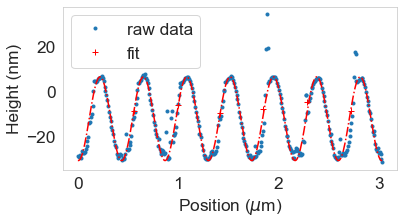

In [33]:
data = np.loadtxt('a1_100um_09_20_2021.000 - NanoScope Analysis.txt')
analyze_afm('a1_100um_09_20_2021.000 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(0,20), 'heights_do':(0,40), 'widths_up':4, 'widths_do':10})
plt.legend()
# plt.savefig('afm_a1_100.svg')

# Dose A (SA2, 50$\mu$m thickness)

AFM Data from sa2_09_20_2021.001 - NanoScope Analysis.txt
Measured list of periods: [0.407 0.487 0.468 0.497 0.447 0.488 0.437 0.438 0.487 0.447 0.498 0.397
 0.487]
Avg = 0.4603846153846155 +/- 0.032787282857226166
CORRECTION FACTOR = 0.9340016708437758
Corrected list of periods: [0.3801386800334168, 0.4548588137009188, 0.43711278195488706, 0.4641988304093565, 0.41749874686716787, 0.4557928153717626, 0.4081587301587303, 0.40909273182957384, 0.45485881370091874, 0.41749874686716787, 0.46513283208020034, 0.37079866332497924, 0.4548588137009185]

Corrected list of diameters: [0.2419064327485379, 0.20454636591478698, 0.2316324143692564, 0.27833249791144526, 0.2045463659147872, 0.19427234753550512, 0.19520634920634922]
Avg = 0.22149182480009544 +/- 0.02867695246227346
Corrected list of depths: [25.678800378910278, 23.606427980543355, 24.064711664735274, 24.46447832266078, 24.180828017414385, 25.652124349817132, 28.1112844579236]
Avg = 25.108379310286402 +/- 1.4272119686052844
Summary: perio

(array([0.        , 0.00934002, 0.01868003, 0.02802005, 0.03736007,
        0.04670008, 0.0560401 , 0.06538012, 0.07472013, 0.08312615,
        0.09246617, 0.10180618, 0.1111462 , 0.12048622, 0.12982623,
        0.13916625, 0.14850627, 0.15784628, 0.1671863 , 0.17652632,
        0.18586633, 0.19520635, 0.20454637, 0.21388638, 0.2232264 ,
        0.23256642, 0.24190643, 0.25031245, 0.25965246, 0.26899248,
        0.2783325 , 0.28767251, 0.29701253, 0.30635255, 0.31569256,
        0.32503258, 0.3343726 , 0.34371261, 0.35305263, 0.36239265,
        0.37173266, 0.38107268, 0.3904127 , 0.39975272, 0.40815873,
        0.41749875, 0.42683876, 0.43617878, 0.4455188 , 0.45485881,
        0.46419883, 0.47353885, 0.48287886, 0.49221888, 0.5015589 ,
        0.51089891, 0.52023893, 0.52957895, 0.53891896, 0.54825898,
        0.557599  , 0.56693901, 0.57534503, 0.58468505, 0.59402506,
        0.60336508, 0.6127051 , 0.62204511, 0.63138513, 0.64072515,
        0.65006516, 0.65940518, 0.6687452 , 0.67

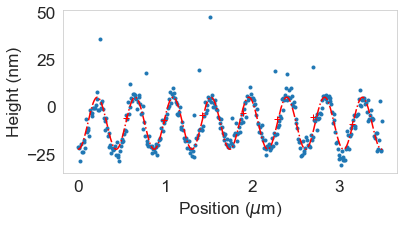

In [34]:
analyze_afm('sa2_09_20_2021.001 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(0,20), 'heights_do':(0,40), 'widths_up':4, 'widths_do':10})
# plt.savefig('afm_sa2.svg')

# Dose A (A2, 50$\mu$m thickness)

AFM Data from a2_09_20_2021.000 - NanoScope Analysis.txt
Measured list of periods: [0.475 0.475 0.506 0.496 0.485 0.465 0.506 0.496 0.485 0.496 0.475 0.506
 0.454]
Avg = 0.48615384615384616 +/- 0.01600406753031219
CORRECTION FACTOR = 0.8844936708860759
Corrected list of periods: [0.42013449367088607, 0.42013449367088596, 0.4475537974683544, 0.43870886075949383, 0.4289794303797467, 0.4112895569620252, 0.4475537974683546, 0.4387088607594936, 0.4289794303797468, 0.4387088607594936, 0.4201344936708861, 0.4475537974683542, 0.40156012658227863]

Corrected list of diameters: [0.2016645569620253, 0.20078006329113932, 0.21846993670886064, 0.22819936708860777, 0.20962499999999967, 0.18309018987341757, 0.15478639240506312]
Avg = 0.19951650090415907 +/- 0.02255450012266044
Corrected list of depths: [28.906728336108745, 27.316273166887633, 28.553957905569817, 25.491613664478827, 25.507539396961292, 24.982966660155892, 30.856985431724166]
Avg = 27.373723508840904 +/- 2.0220276284695142
Summary: peri

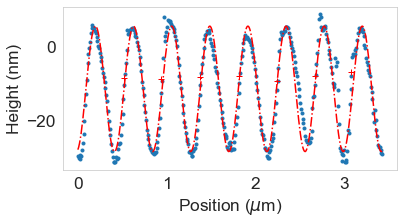

In [35]:
x_afm,y_afm,y0_afm,popt= analyze_afm('a2_09_20_2021.000 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(0,20), 'heights_do':(0,40), 'widths_up':4, 'widths_do':10})
# plt.legend()
# plt.savefig('afm_a2_50.svg')


# Dose B (B1, 100$\mu$m thickness)

AFM Data from b1_09_20_2021.000 - NanoScope Analysis.txt
Measured list of periods: [0.47  0.489 0.508 0.489 0.508 0.47  0.479 0.489 0.508 0.47  0.498]
Avg = 0.4889090909090909 +/- 0.01460668928610543
CORRECTION FACTOR = 0.8795091111937523
Corrected list of periods: [0.41336928226106356, 0.43007995537374494, 0.4467906284864262, 0.43007995537374477, 0.4467906284864262, 0.41336928226106373, 0.42128486426180733, 0.43007995537374494, 0.4467906284864262, 0.41336928226106334, 0.4379955373744888]

Corrected list of diameters: [0.17150427668278165, 0.22427482335440685, 0.20668464113053187, 0.18909445890665663, 0.18909445890665663, 0.17150427668278156]
Avg = 0.1920261559439692 +/- 0.018772020356425848
Corrected list of depths: [16.292284320260748, 13.243030769770971, 17.170362683263132, 15.338441400835299, 14.38027970974235, 15.862984863628578]
Avg = 15.381230624583514 +/- 1.2805423185348022
Summary: period = 0.43 (corrected by factor 0.8795091111937523)

Diameter = 192.0261559439692 +/- 0.01877

(array([0.        , 0.00879509, 0.01759018, 0.02550576, 0.03430086,
        0.04309595, 0.05189104, 0.05980662, 0.06860171, 0.0773968 ,
        0.08619189, 0.09498698, 0.10290257, 0.11169766, 0.12049275,
        0.12928784, 0.13720342, 0.14599851, 0.1547936 , 0.16358869,
        0.17238379, 0.18029937, 0.18909446, 0.19788955, 0.20668464,
        0.21460022, 0.22339531, 0.23219041, 0.2409855 , 0.24978059,
        0.25769617, 0.26649126, 0.27528635, 0.28408144, 0.29199702,
        0.30079212, 0.30958721, 0.3183823 , 0.32717739, 0.33509297,
        0.34388806, 0.35268315, 0.36147824, 0.36939383, 0.37818892,
        0.38698401, 0.3957791 , 0.40457419, 0.41248977, 0.42128486,
        0.43007996, 0.43887505, 0.44679063, 0.45558572, 0.46438081,
        0.4731759 , 0.48197099, 0.48988657, 0.49868167, 0.50747676,
        0.51627185, 0.52418743, 0.53298252, 0.54177761, 0.5505727 ,
        0.55936779, 0.56728338, 0.57607847, 0.58487356, 0.59366865,
        0.60158423, 0.61037932, 0.61917441, 0.62

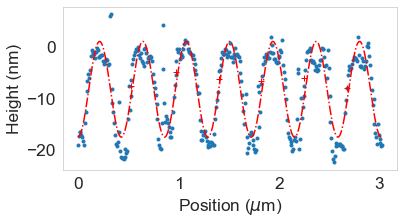

In [36]:
analyze_afm('b1_09_20_2021.000 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(-5,5), 'heights_do':(0,40), 'widths_up':4, 'widths_do':10, 'savgol_window':51, 'savgol_order':5})
# plt.savefig('afm_b1_100.svg')

# Dose A (A1, 50$\mu$m thickness)

AFM Data from a11_09_20_2021.000 - NanoScope Analysis.txt
Measured list of periods: [0.505 0.514 0.494 0.505 0.494 0.515 0.504 0.494 0.494]
Avg = 0.5021111111111112 +/- 0.008102735401557539
CORRECTION FACTOR = 0.8563841557866784
Corrected list of periods: [0.4324739986722726, 0.4401814560743528, 0.4230537729586191, 0.4324739986722725, 0.4230537729586193, 0.44103784023013937, 0.4316176145164858, 0.4230537729586193, 0.4230537729586191]

Corrected list of diameters: [0.22009072803717636, 0.22951095375082992, 0.22009072803717625, 0.22094711219296304, 0.22094711219296304]
Avg = 0.2223173268422217 +/- 0.0036171460835193667
Corrected list of depths: [27.588993263698793, 26.55241888913503, 21.7993275979782, 24.960819343361695, 26.863594905810398]
Avg = 25.553030799996822 +/- 2.0640978717094027
Summary: period = 0.43 (corrected by factor 0.8563841557866784)

Diameter = 222.3173268422217 +/- 0.0036171460835193667 nm , Depth = 25.553030799996822 +/- 2.0640978717094027 nm

Sin^2 fit: period=0.428,

(array([0.        , 0.00856384, 0.01798407, 0.02654791, 0.03511175,
        0.04367559, 0.05309582, 0.06165966, 0.0702235 , 0.07964373,
        0.08820757, 0.09677141, 0.10619164, 0.11475548, 0.12331932,
        0.13188316, 0.14130339, 0.14986723, 0.15843107, 0.16785129,
        0.17641514, 0.18497898, 0.19354282, 0.20296304, 0.21152689,
        0.22009073, 0.22951095, 0.2380748 , 0.24663864, 0.25605886,
        0.2646227 , 0.27318655, 0.28175039, 0.29117061, 0.29973445,
        0.3082983 , 0.31771852, 0.32628236, 0.3348462 , 0.34341005,
        0.35283027, 0.36139411, 0.36995796, 0.37937818, 0.38794202,
        0.39650586, 0.40592609, 0.41448993, 0.42305377, 0.43161761,
        0.44103784, 0.44960168, 0.45816552, 0.46758575, 0.47614959,
        0.48471343, 0.49327727, 0.5026975 , 0.51126134, 0.51982518,
        0.52924541, 0.53780925, 0.54637309, 0.55579332, 0.56435716,
        0.572921  , 0.58148484, 0.59090507, 0.59946891, 0.60803275,
        0.61745298, 0.62601682, 0.63458066, 0.64

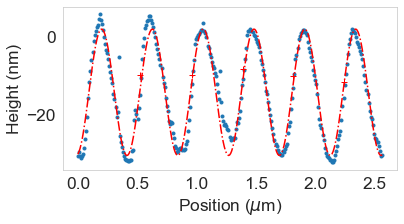

In [37]:
analyze_afm('a11_09_20_2021.000 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(-5,5), 'heights_do':(0,40), 'widths_up':4, 'widths_do':10, 'savgol_window':51, 'savgol_order':5})
# plt.savefig('afm_a1_50.svg')

# Calibration sample (to measure height correction factor)

AFM Data from calibration_std_21p2_depth_500nm_pitch.000 - NanoScope Analysis.txt
Measured list of periods: [0.551 0.55  0.564 0.702 0.551 0.564 0.551 0.55  0.578 0.551 0.454]
Avg = 0.5605454545454546 +/- 0.05416869883876027
CORRECTION FACTOR = 0.7671099578332792
Corrected list of periods: [0.42267758676613687, 0.4219104768083035, 0.4326500162179695, 0.5385111903989621, 0.4226775867661366, 0.4326500162179695, 0.42267758676613676, 0.42191047680830357, 0.44338955562763543, 0.4226775867661369, 0.34826792085630853]

Corrected list of diameters: [0.21095523840415176, 0.21095523840415178, 0.21172234836198506, 0.2216947778138178, 0.2109552384041517, 0.19024326954265341]
Avg = 0.20942101848848527 +/- 0.009405573117759206
Corrected list of depths: [22.883318225118522, 21.35220765561621, 22.243078586878877, 21.347099832134514, 20.783450550719497, 18.593245464213364]
Avg = 21.20040005244683 +/- 1.350003728991882
Summary: period = 0.43 (corrected by factor 0.7671099578332792)

Diameter = 209.42101

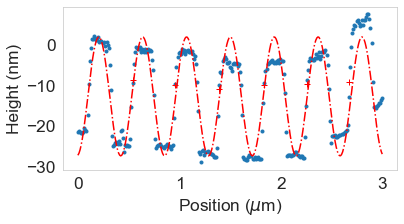

In [38]:
analyze_afm('calibration_std_21p2_depth_500nm_pitch.000 - NanoScope Analysis.txt', 0.430, params = {'heights_up':(-10,10), 'heights_do':(0,30), 'widths_up':10, 'widths_do':10, 'savgol_window':21, 'savgol_order':5});